# 🎯 TicketCluster — Unsupervised Customer Support Ticket Intelligence

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RansiluRanasinghe/TicketCluster-Unsupervised-ML/blob/main/notebook.ipynb)

---

## 📌 Project Overview

This notebook implements **TicketCluster**, an unsupervised NLP system that analyzes and groups customer support tickets using **K-Means clustering**.

**Goal:** Simulate how real organizations explore unlabeled support tickets to identify recurring issues, emerging patterns, and operational insights—without predefined categories.

---

## 🎯 Workflow

1. **Minimal, production-oriented text preprocessing**
2. **Vectorization** of ticket content (Subject + Body)
3. **Unsupervised clustering** to discover natural groupings
4. **Cluster interpretation** from business perspectives

This notebook emphasizes **model reasoning and reliability** over aggressive tuning, reflecting real customer-support analytics pipelines.

---

**Author:** Ransilu Ranasinghe | [GitHub](https://github.com/RansiluRanasinghe) | [LinkedIn](https://www.linkedin.com/in/ransilu-ranasinghe-a596792ba)

---

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

###Loading the Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tobiasbueck/multilingual-customer-support-tickets")

print("Path to dataset files:", path)

100%|██████████| 16.1M/16.1M [00:00<00:00, 107MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tobiasbueck/multilingual-customer-support-tickets/versions/14


In [3]:
import os

files = os.listdir(path)

print("Available files: ")
for file in files:
  print(" - ", file)

Available files: 
 -  aa_dataset-tickets-multi-lang-5-2-50-version.csv
 -  dataset-tickets-multi-lang3-4k.csv
 -  dataset-tickets-german_normalized_50_5_2.csv
 -  dataset-tickets-german_normalized.csv
 -  dataset-tickets-multi-lang-4-20k.csv


In [4]:
dataset_path = os.path.join(path, "dataset-tickets-multi-lang-4-20k.csv")

df = pd.read_csv(dataset_path)
print("Shape:", df.shape)
print("Columns:", len(df.columns))

Shape: (20000, 15)
Columns: 15


In [5]:
display(df.head())

,subject,body,answer,type,queue,priority,language,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8
0,Unvorhergesehener Absturz der Datenanalyse-Pla...,Die Datenanalyse-Plattform brach unerwartet ab...,Ich werde Ihnen bei der Lösung des Problems he...,Incident,General Inquiry,low,de,Crash,Technical,Bug,Hardware,Resolution,Outage,Documentation,NaN
1,Customer Support Inquiry,Seeking information on digital strategies that...,We offer a variety of digital strategies and s...,Request,Customer Service,medium,en,Feedback,Sales,IT,Tech Support,NaN,NaN,NaN,NaN
2,Data Analytics for Investment,I am contacting you to request information on ...,I am here to assist you with data analytics to...,Request,Customer Service,medium,en,Technical,Product,Guidance,Documentation,Performance,Feature,NaN,NaN
3,Krankenhaus-Dienstleistung-Problem,Ein Medien-Daten-Sperrverhalten trat aufgrund ...,Zurück zur E-Mail-Beschwerde über den Sperrver...,Incident,Customer Service,high,de,Security,Breach,Login,Maintenance,Incident,Resolution,Feedback,NaN
4,Security,"Dear Customer Support, I am reaching out to in...","Dear [name], we take the security of medical d...",Request,Customer Service,medium,en,Security,Customer,Compliance,Breach,Documentation,Guidance,NaN,NaN


In [6]:
print(df.dtypes)

subject     object
body        object
answer      object
type        object
queue       object
priority    object
language    object
tag_1       object
tag_2       object
tag_3       object
tag_4       object
tag_5       object
tag_6       object
tag_7       object
tag_8       object
dtype: object


###Data quality analysis

In [7]:
def quality_analysis(df):

  print("Missing Values: ")

  missing = df.isna().sum()
  missing_pct = (missing / len(df)) * 100

  for col in df.columns:
    if missing[col] > 0:
      print(f" - {col}: {missing[col]} ({missing_pct[col]:.2f}%)")
    else:
      print(col, "Complete")

  print("\n Ticket lenght")

  df["combined_text"] = df["subject"].fillna("") + " " + df['body'].fillna("")
  df["text_lenght"] = df["combined_text"].str.len()

  print("Average characters per ticket:", df["text_lenght"].mean())
  print("Shortest ticket:", df["text_lenght"].min())
  print("Maximum ticket:", df["text_lenght"].max())

  print("\n Language Analysis")

  lang_count = df["language"].value_counts()
  for lang, count in lang_count.items():
    pct = count / len(df) * 100
    print(f"   {lang}: {count} tickets ({pct:.1f}%)")

  print("\n Priority Distribution")

  if "priority" in df.columns:
    priority_map = {1: 'Low', 2: 'Medium', 3: 'Critical'}
    df["priority_label"] = df["priority"].map(priority_map)

    priority_counts = df["priority_label"].value_counts()
    for prio, count in priority_counts.items():
      pct = count / len(df) * 100
      print(f"   {prio}: {count} tickets ({pct:.1f}%)")

  print("\n Queue Distribution")

  if "queue" in df.columns:
    queue_counts =  df['queue'].value_counts().head(10)
    for queue, count in queue_counts.items():
      pct = count / len(df) * 100
      print(f"   {queue}: {count} tickets ({pct:.1f}%)")

  return df

In [8]:
df = quality_analysis(df)

Missing Values: 
 - subject: 1461 (7.31%)
 - body: 2 (0.01%)
 - answer: 4 (0.02%)
type Complete
queue Complete
priority Complete
language Complete
tag_1 Complete
 - tag_2: 46 (0.23%)
 - tag_3: 95 (0.47%)
 - tag_4: 1539 (7.70%)
 - tag_5: 6909 (34.54%)
 - tag_6: 12649 (63.24%)
 - tag_7: 16072 (80.36%)
 - tag_8: 18093 (90.46%)

 Ticket lenght
Average characters per ticket: 437.0327
Shortest ticket: 5
Maximum ticket: 2284

 Language Analysis
   en: 11923 tickets (59.6%)
   de: 8077 tickets (40.4%)

 Priority Distribution

 Queue Distribution
   Technical Support: 5824 tickets (29.1%)
   Product Support: 3708 tickets (18.5%)
   Customer Service: 3152 tickets (15.8%)
   IT Support: 2292 tickets (11.5%)
   Billing and Payments: 2086 tickets (10.4%)
   Returns and Exchanges: 1001 tickets (5.0%)
   Service Outages and Maintenance: 764 tickets (3.8%)
   Sales and Pre-Sales: 572 tickets (2.9%)
   Human Resources: 338 tickets (1.7%)
   General Inquiry: 263 tickets (1.3%)


####Field Examination

In [9]:
def feild_examination(df, sample_size=5):

  print("\n Sample tickets from queues:")
  queues = df["queue"].dropna().unique()[:3]

  for queue in queues:
    print(f" Queue- {queue}:")
    sample_tickets = df[df["queue"] == queue].head(sample_size)

    for idx, row in sample_tickets.iterrows():
      subject = str(row['subject'])[:80] + "..." if len(str(row['subject'])) > 80 else str(row['subject'])
      print(f"   • {subject}")


  print("\n Subject + Body examples:")

  for i in range(50):
    print(f"\nExample {i+1}:")
    print(f"   Subject: {df.iloc[i]['subject']}")
    print(f"   Body preview: {str(df.iloc[i]['body'])[:150]}...")
    print(f"   Combined: {df.iloc[i]['combined_text'][:200]}...")

    return df

In [10]:
df = feild_examination(df)


 Sample tickets from queues:
 Queue- General Inquiry:
   • Unvorhergesehener Absturz der Datenanalyse-Plattform
   • Services in Data Analytics
   • Probleme mit den Social-Media-Verfolgungsdaten
   • Enquire About Integrating Airtable with Cassandra
   • Request for Robust Encryption Implementation
 Queue- Customer Service:
   • Customer Support Inquiry
   • Data Analytics for Investment
   • Krankenhaus-Dienstleistung-Problem
   • Security
   • Request for Assistance with Data Integration
 Queue- Technical Support:
   • Concerns About Securing Medical Data on 2-in-1 Convertible Laptop with Norton 36...
   • Ratung für Sicherung medizinischer Daten in HubSpot CRM PostgreSQL-Umgebungen
   • Issue with Data Analytics Platform - Insufficient RAM Allocation
   • Reported Issue with Project Sync Resulting in Data Loss
   • Strategies for Brand Expansion

 Subject + Body examples:

Example 1:
   Subject: Unvorhergesehener Absturz der Datenanalyse-Plattform
   Body preview: Die Datenanalyse

####Moodel Input Creation

In [11]:
def create_model_input(df):

  df["final_text"] = df["subject"].fillna("") + " " + df["body"].fillna("")

  initial_count = len(df)
  df = df[df["final_text"].str.strip() != ""].copy()
  final_count = len(df)

  print(f"   Initial tickets: {initial_count}")
  print(f"   After removing empty: {final_count}")
  print(f"   Removed: {initial_count - final_count} ({(initial_count - final_count)/initial_count*100:.1f}%)")

  df["final_text_length"] = df["final_text"].str.len()

  def categorize_length(length):
        if length < 50:
            return 'Very Short (< 50 chars)'
        elif length < 200:
            return 'Short (50-200 chars)'
        elif length < 500:
            return 'Medium (200-500 chars)'
        elif length < 1000:
            return 'Long (500-1000 chars)'
        else:
            return 'Very Long (> 1000 chars)'

  df['length_category'] = df['final_text_length'].apply(categorize_length)

  print("Lenght distribution:\n")

  length_counts = df['length_category'].value_counts()
  for category, count in length_counts.items():
      pct = count / len(df) * 100
      print(f"   {category}: {count} tickets ({pct:.1f}%)")

  return df

In [12]:
df = create_model_input(df)

   Initial tickets: 20000
   After removing empty: 20000
   Removed: 0 (0.0%)
Lenght distribution:

   Medium (200-500 chars): 8773 tickets (43.9%)
   Long (500-1000 chars): 6985 tickets (34.9%)
   Short (50-200 chars): 3645 tickets (18.2%)
   Very Long (> 1000 chars): 558 tickets (2.8%)
   Very Short (< 50 chars): 39 tickets (0.2%)


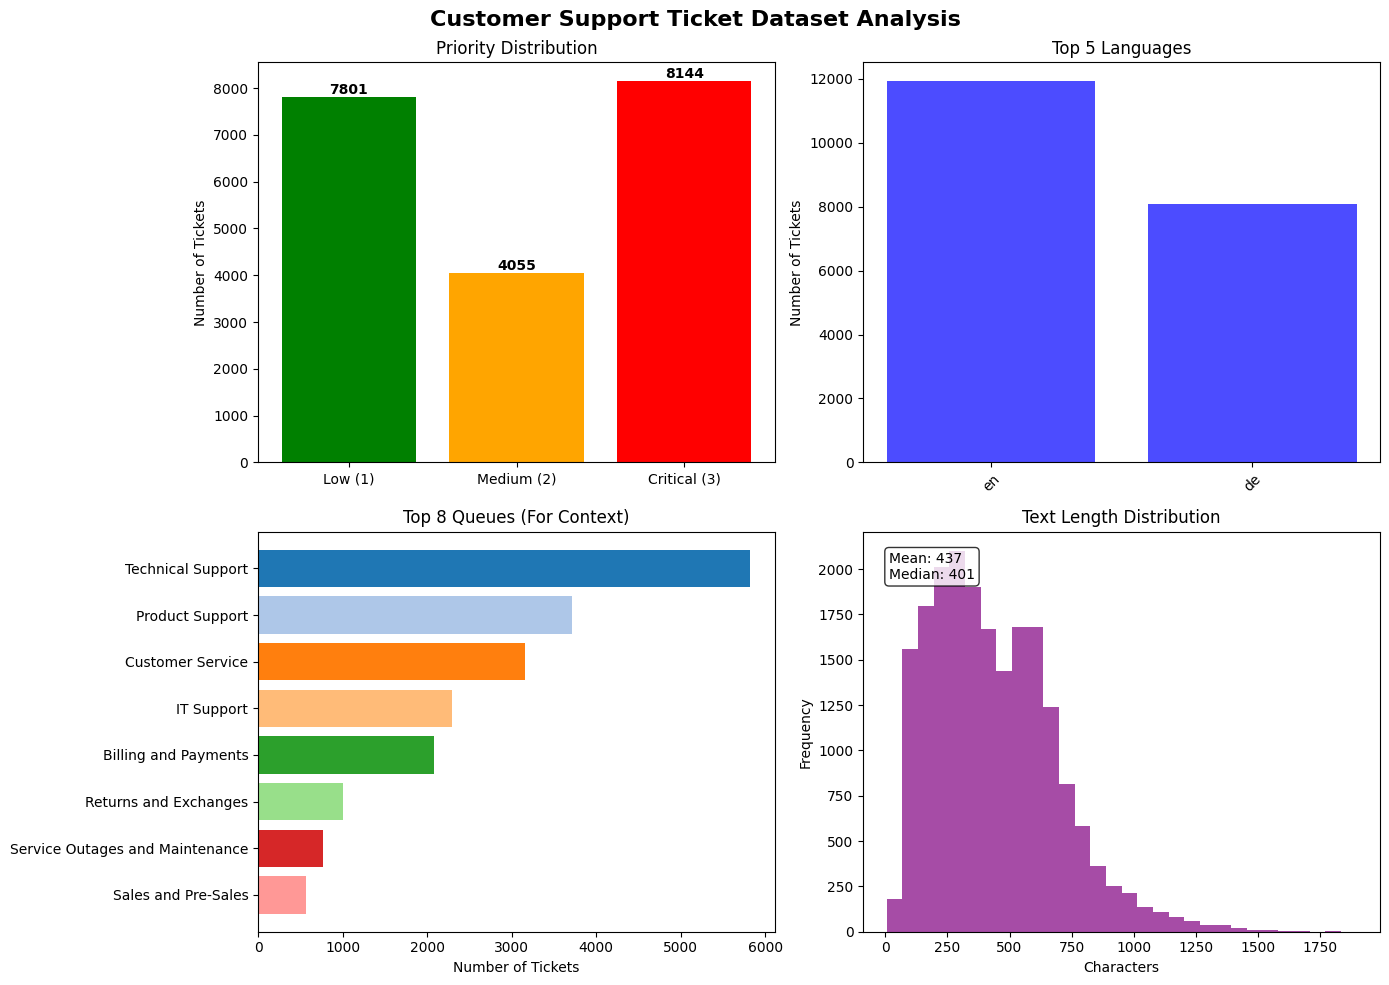

✅ Minimal visualization created successfully!


In [13]:
def create_business_visualizations(df):

 print("CREATING MINIMAL VISUALIZATION")
 print("=" * 60)

try:

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))


    if 'priority' in df.columns:
        priority_data = df['priority'].value_counts().sort_index()
        axes[0,0].bar(['Low (1)', 'Medium (2)', 'Critical (3)'][:len(priority_data)],
                     priority_data.values,
                     color=['green', 'orange', 'red'][:len(priority_data)])
        axes[0,0].set_title('Priority Distribution')
        axes[0,0].set_ylabel('Number of Tickets')

        for i, v in enumerate(priority_data.values):
            axes[0,0].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

    lang_data = df['language'].value_counts().head(5)
    axes[0,1].bar(lang_data.index, lang_data.values, color='blue', alpha=0.7)
    axes[0,1].set_title('Top 5 Languages')
    axes[0,1].set_ylabel('Number of Tickets')
    axes[0,1].tick_params(axis='x', rotation=45)

    queue_data = df['queue'].value_counts().head(8)
    axes[1,0].barh(range(len(queue_data)), queue_data.values,
                   color=plt.cm.tab20(np.arange(len(queue_data))))
    axes[1,0].set_yticks(range(len(queue_data)))
    axes[1,0].set_yticklabels(queue_data.index)
    axes[1,0].set_title('Top 8 Queues (For Context)')
    axes[1,0].set_xlabel('Number of Tickets')
    axes[1,0].invert_yaxis()


    if 'final_text' in df.columns:
        text_lengths = df['final_text'].str.len()

        reasonable_lengths = text_lengths[text_lengths < 2000]
        axes[1,1].hist(reasonable_lengths, bins=30, alpha=0.7, color='purple')
        axes[1,1].set_title('Text Length Distribution')
        axes[1,1].set_xlabel('Characters')
        axes[1,1].set_ylabel('Frequency')

        axes[1,1].text(0.05, 0.95,
                      f'Mean: {text_lengths.mean():.0f}\nMedian: {text_lengths.median():.0f}',
                      transform=axes[1,1].transAxes,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.suptitle('Customer Support Ticket Dataset Analysis', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("✅ Minimal visualization created successfully!")

except Exception as e:
    print(f" Visualization error: {e}")
    print("\nUsing text-based visualization instead...")

    if 'priority' in df.columns:
        print("\nPRIORITY DISTRIBUTION:")
        print("-" * 30)
        priority_counts = df['priority'].value_counts().sort_index()
        max_count = priority_counts.max()

        for prio, count in priority_counts.items():
            bar_length = int((count / max_count) * 50)
            bar = '█' * bar_length
            pct = (count / len(df)) * 100
            label = {1: "Low", 2: "Medium", 3: "Critical"}.get(prio, f"Level {prio}")
            print(f"{label}: {bar} {count:,} ({pct:.1f}%)")

    print("\nLANGUAGE DISTRIBUTION:")
    print("-" * 30)
    lang_counts = df['language'].value_counts().head(5)
    for lang, count in lang_counts.items():
        pct = (count / len(df)) * 100
        print(f"{lang}: {count:,} tickets ({pct:.1f}%)")

    plt.savefig("Customer Support Ticket Dataset Analysis.png")

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import joblib
from tqdm import tqdm

####TF-IDF Vectorization

In [16]:
def tf_idf_vectorization(tickets, max_features=8000, min_df=5, max_df=0.8):

  print("Max Features:", max_features)
  print("Min Document Frequency:", min_df)
  print("Max Document Frequency:", max_df)

  vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, max_df=max_df,
                               stop_words="english", ngram_range=(1, 2), sublinear_tf=True)

  tfidf_metrix = vectorizer.fit_transform(tickets)

  feature_names = vectorizer.get_feature_names_out()

  print("Vocab size: ", len(feature_names))
  print("Shapes: ", tfidf_metrix.shape)

  print("\n Important words: ")

  term_scores = np.array(tfidf_metrix.mean(axis=0)).flatten()
  top_indices = term_scores.argsort()[-20:][::-1]

  top_terms = []
  for idx in top_indices:
      term = feature_names[idx]
      score = term_scores[idx]
      top_terms.append((term, score))
      print(f"   {term:20s}: {score:.4f}")

  return tfidf_metrix, vectorizer, top_terms

In [20]:
tickets = df["final_text"].tolist()

tfidf_metrix, vectorizer, top_terms = tf_idf_vectorization(tickets)

Max Features: 8000
Min Document Frequency: 5
Max Document Frequency: 0.8
Vocab size:  8000
Shapes:  (20000, 8000)

 Important words: 
   data                : 0.0311
   issue               : 0.0221
   die                 : 0.0216
   problem             : 0.0213
   und                 : 0.0208
   support             : 0.0200
   zu                  : 0.0191
   software            : 0.0189
   der                 : 0.0168
   integration         : 0.0165
   medical             : 0.0162
   assistance          : 0.0160
   investment          : 0.0159
   analytics           : 0.0158
   information         : 0.0156
   ich                 : 0.0154
   security            : 0.0147
   provide             : 0.0143
   project             : 0.0142
   digital             : 0.0141


In [21]:
joblib.dump(vectorizer, "vectorizer.pkl")
print("\nTF-IDF vectorizer saved: 'vectorizer.pkl'")


TF-IDF vectorizer saved: 'vectorizer.pkl'
